In [1]:
# REMEMBER TO INSTALL BOTH UTIDE AND PYTMD
from utide import solve, reconstruct
import utide
from xmitgcm import open_mdsdataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from os.path import expanduser,join,isdir
import sys
user_home_dir = expanduser('~')
ecco_v4_py_dir = join(user_home_dir,'ECCOv4-py')
if isdir(ecco_v4_py_dir):
    sys.path.insert(0,ecco_v4_py_dir)
from ecco_v4_py import plot_proj_to_latlon_grid
import ecco_v4_py as ecco
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# import tide programs
import pyTMD.crs
import pyTMD.io
import pyTMD.tools
from pyTMD.solve import constants
from datetime import datetime, timedelta
import pyTMD
import xarray as xr

# OUR RUN

In [2]:
data_dir ='/efs_ecco/hvanderz/export_tides'
grid_dir ='/efs_ecco/hvanderz/r5/WORKINGDIR/ECCOV4/release5_ToTs/run'
ds_llc = open_mdsdataset(data_dir, 
                        grid_dir=grid_dir, 
                         prefix={'ETAN'},
                         geometry="llc") #non-native grid

# display the contents of the Dataset
ds_llc = ds_llc.rename({'face':'tile'})

In [3]:
ds_llc['time'] = xr.cftime_range(start='1992-01-01', periods=ds_llc.dims['time'], freq='h')

In [4]:
ds_llc = ds_llc.unify_chunks()

In [5]:
ds_clm = ds_llc.groupby('time.month').mean('time')
#ds_clm = ds_llc.mean('time')
ds_llc_anom = ds_llc.groupby('time.month') - ds_clm
#ds_llc_anom = ds_llc - ds_clm

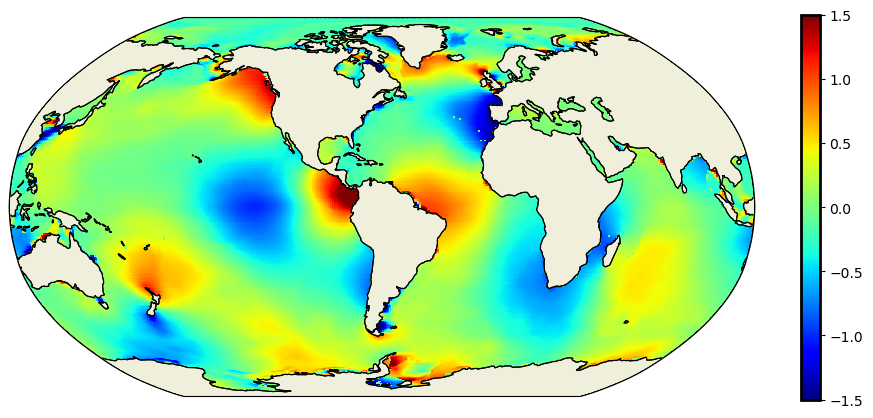

In [52]:
plt.figure(figsize=[12,5]);
jet_colMap_k = cm.jet
jet_colMap_k.set_bad(color='black')

jet_colMap_w = cm.jet
jet_colMap_w.set_bad(color='white')

X = plot_proj_to_latlon_grid(ds_llc_anom.XC, ds_llc_anom.YC,ds_llc_anom.ETAN.isel(time=10100), 
                                 cmap=jet_colMap_w, cmin= -1.5, cmax = 1.5,
                                  show_colorbar=True, user_lon_0=-66)

In [6]:
n_files = len(ds_llc_anom.time)              # number of data files
start_time = '1992-01-01'    # starting date
freq = 'h'                   # time frequency (e.g. 'h
time_eta = pd.date_range(start=start_time, periods=n_files, freq=freq)
latp = ds_llc_anom['YC'].isel(tile=4, j=45, i=45).values

# pyTMD

In [7]:
epoch = datetime(1992, 1, 1)
t = np.array([(ti.to_pydatetime() - epoch).total_seconds() / 86400.0 for ti in time_eta])

In [8]:
ht_mod = ds_llc.isel(tile=4, i=45, j=45).ETAN.values

In [9]:
constituents = ['m2', 's2', 'n2', 'k2','k1', 'o1', 'p1', 'q1', 'mm', 'mf', 'm4', 'mn4', 'ms4', '2n2']

In [10]:
amp_fit, phase_fit = constants(
    t=t,
    ht=ht_mod,
    constituents=constituents,
    deltat=0.0,
    corrections='OTIS',
    solver='lstsq'
)

In [11]:
# Convert phase from degrees to radians
ph_rad = np.deg2rad(phase_fit)

# Harmonic constants: complex vector
hc = amp_fit * np.exp(-1j * ph_rad)

In [12]:
# Predict tidal elevations
ht_fit = pyTMD.predict.time_series(
    t=t,
    hc=hc,
    constituents=constituents,
    deltat=0.0,               # Use 0 unless you have leap second correction
    corrections='OTIS'  # Should be 'OTIS' or similar
)

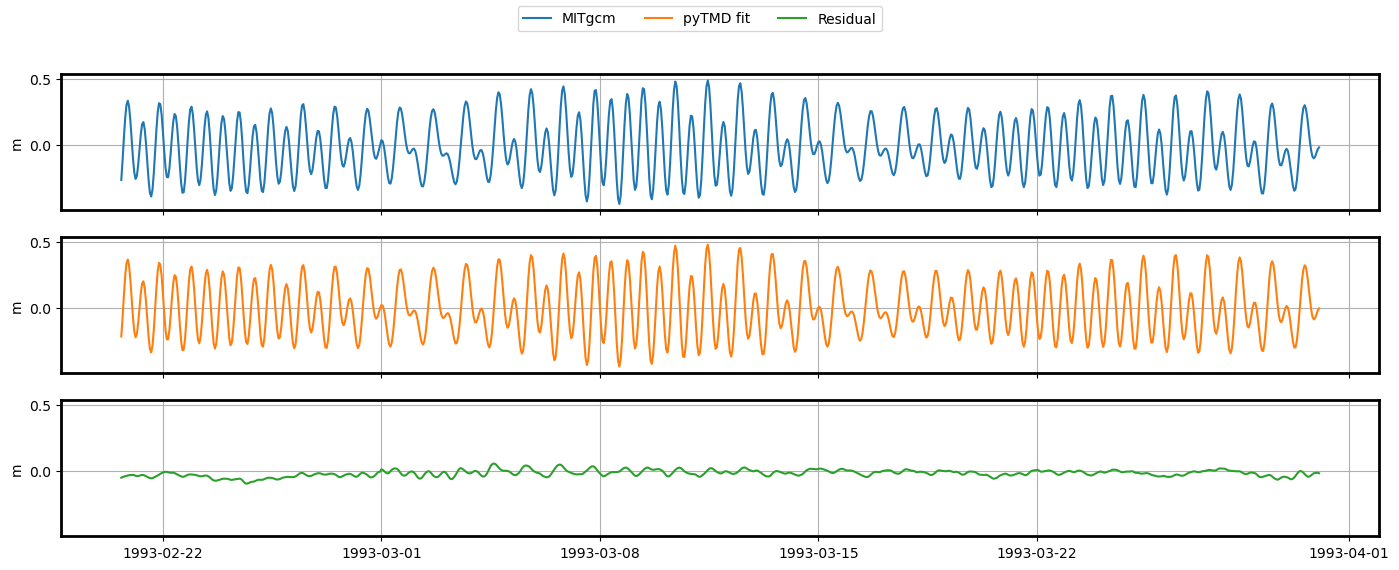

In [13]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(time_eta[10000:11000],  ds_llc_anom.isel(tile=4, i=45,j=45, time = slice(10000, 11000)).ETAN.values, label="MITgcm", color="C0")
ax1.plot(time_eta[10000:11000], ht_fit[10000:11000], label="pyTMD fit", color="C1")
ax2.plot(time_eta[10000:11000],  ds_llc_anom.isel(tile=4, i=45,j=45, time = slice(10000, 11000)).ETAN.values - ht_fit[10000:11000], label="Residual", color="C2")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

# TPXO

In [14]:
# available model list
model_list = sorted(pyTMD.io.model.ocean_elevation())
# display widgets for setting directory and model
TMDwidgets = pyTMD.tools.widgets()
TMDwidgets.model.options = model_list
TMDwidgets.model.value = 'TPXO9.1'
TMDwidgets.VBox([
    TMDwidgets.directory,
    TMDwidgets.model,
    TMDwidgets.compress
])
# the directory is /efs_ecco/hvanderz/TMD

In [15]:
# get model parameters
model = pyTMD.io.model(TMDwidgets.directory.value,
    compressed=TMDwidgets.compress.value
   ).elevation(TMDwidgets.model.value)

# read tidal constants and interpolate to grid points
if model.format in ('OTIS','ATLAS-compact','TMD3'):
    # if reading a single OTIS solution
    xi,yi,hz,mz,iob,dt = pyTMD.io.OTIS.read_otis_grid(model.grid_file)

In [16]:
amp,ph,D,c = pyTMD.io.OTIS.extract_constants(97.5, -23.85, model.grid_file, model.model_file, 4326,
    type='z',
    method='spline',
    grid='OTIS')

In [17]:
# Convert phase from degrees to radians
ph_rad = np.deg2rad(ph)

# Harmonic constants: complex vector
hc = amp * np.exp(-1j * ph_rad)

In [18]:
# Predict tidal elevations
ht = pyTMD.predict.time_series(
    t=t,
    hc=hc,
    constituents=constituents,
    deltat=0.0,               # Use 0 unless you have leap second correction
    corrections=model.format  # Should be 'OTIS' or similar
)

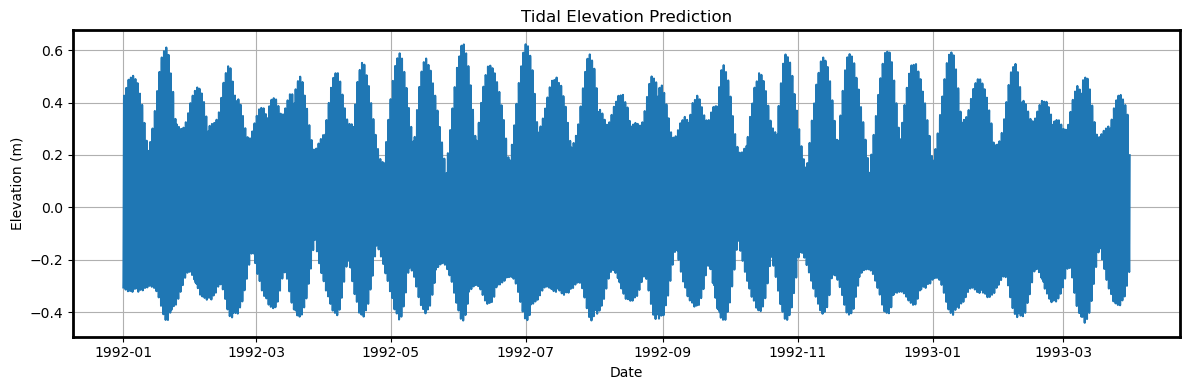

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(time_eta, ht)
plt.title("Tidal Elevation Prediction")
plt.xlabel("Date")
plt.ylabel("Elevation (m)")
plt.grid(True)
plt.tight_layout()
plt.show()

# COMPARISON

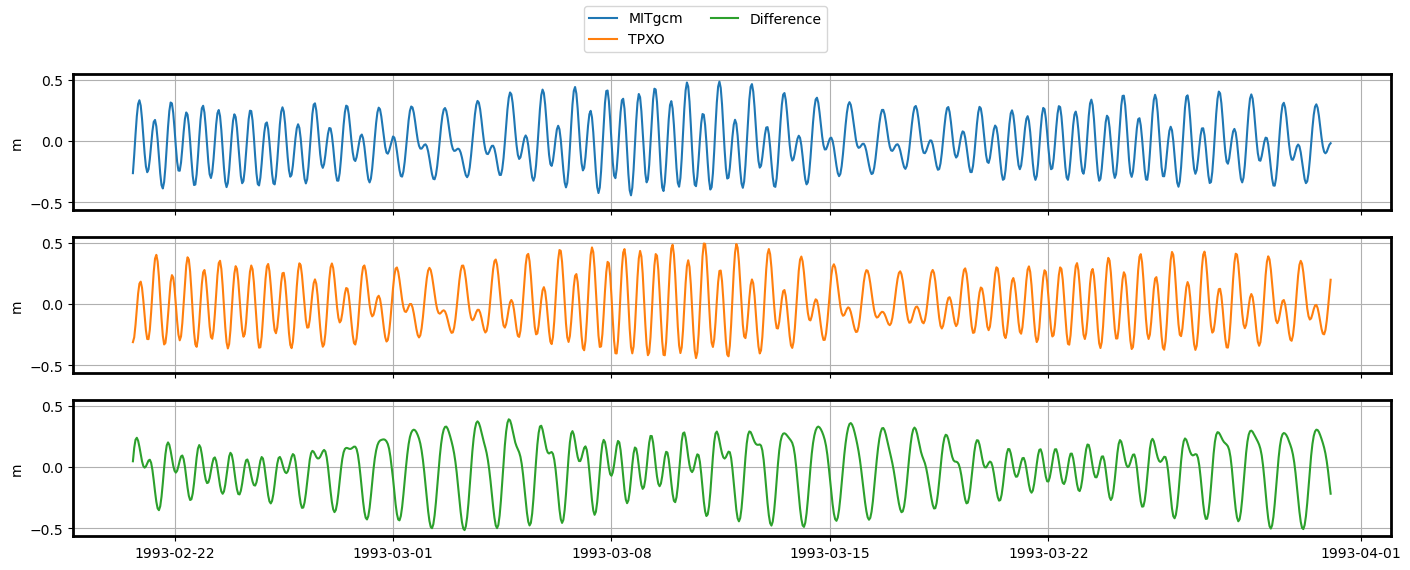

In [20]:
# shift of phase!!!
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(time_eta[10000:11000],  ds_llc_anom.isel(tile=4, i=45,j=45, time = slice(10000, 11000)).ETAN.values, label="MITgcm", color="C0")
ax1.plot(time_eta[10000:11000], ht[10000:11000], label="TPXO", color="C1")
ax2.plot(time_eta[10000:11000], ds_llc_anom.isel(tile=4, i=45,j=45, time = slice(10000, 11000)).ETAN.values-ht[10000:11000], label="Difference", color="C2")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=2, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

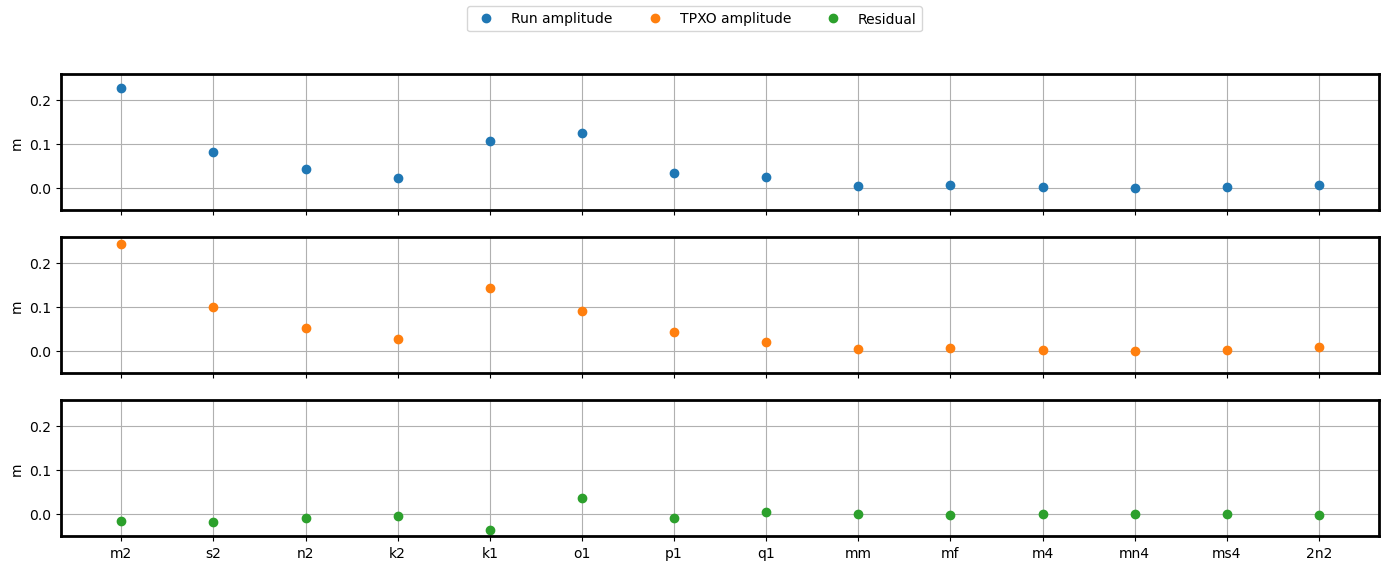

In [21]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents, amp_fit, label="Run amplitude", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, amp.data[0][:14], label="TPXO amplitude", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  amp_fit - amp.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()

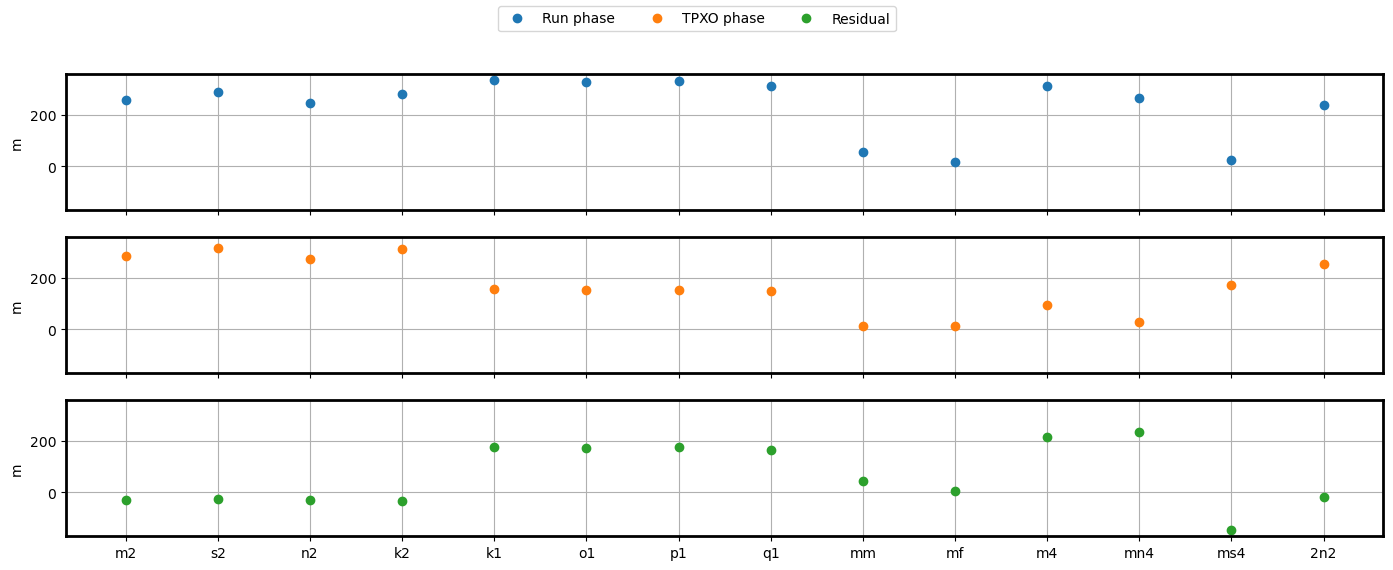

In [22]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 6), nrows=3, sharey=True, sharex=True)

ax0.plot(constituents,  phase_fit, label="Run phase", color="C0", marker = "o", linestyle = "None")
ax1.plot(constituents, ph.data[0][:14], label="TPXO phase", color="C1", marker = "o", linestyle = "None")
ax2.plot(constituents,  phase_fit - ph.data[0][:14], label="Residual", color="C2", marker = "o", linestyle = "None")
ax0.set_ylabel('m')
ax1.set_ylabel('m')
ax2.set_ylabel('m')
fig.legend(ncol=3, loc="upper center")
ax0.grid()
ax1.grid()
ax2.grid()